In [1]:
from mcap_processing import open_files_in_folder, merge_dictionaries, convert_dict_to_pandas_df, get_start_end_times, get_all_msgs_from_mcap, get_important_data_for_times
from functools import reduce

In [3]:
mcap_readers, files = open_files_in_folder("./mcaps/raw")

msgs_total = {}
for reader in mcap_readers:
    msgs_total = merge_dictionaries(msgs_total, get_all_msgs_from_mcap(reader))
df = convert_dict_to_pandas_df(msgs_total)
important_times = get_start_end_times(df, "mcu_status_data", "ecu_state", "5")
cut_df = get_important_data_for_times(df, important_times)

/home/ben/mcap_analysis/./mcaps/raw/07_31_2023_10_37_12.mcap


/home/ben/mcap_analysis/mcap_processing.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[topic_attr_name] = msgs['proto_msg'].apply(lambda x: getattr(x, topic_attr_name))


/tmp/ipykernel_311126/3231758291.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
/tmp/ipykernel_311126/3231758291.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
/tmp/ipykernel_311126/3231758291.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

<Figure size 2400x1200 with 0 Axes>

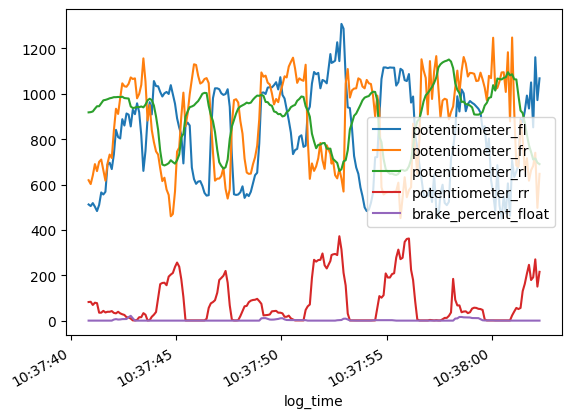

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def column_with_least_values(df, columns_to_check):
    min_count = int('inf')  # Initialize with infinity
    min_column = None
    
    for column in columns_to_check:
        count = df[column].count()  # Count non-null values
        if count < min_count:
            min_count = count
            min_column = column
            
    return min_column

def time_plot_msg_member(df, topic, pb_msg_member):
    msgs = df[df['topic'] == topic]
    msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_member)
    plt.show()

def time_plot_multi_msg_members(df, topic, pb_msg_members_list):
    msgs = df[df['topic'] == topic]
    plt.figure(figsize=(16, 8), dpi=150) 
    for pb_msg_member in pb_msg_members_list:
        msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_members_list)
    plt.show()

def multi_topic_time_plot_multi_msg_members(df, topic_msg_member_list_dict):
    member_list = []
    msgs_to_plot = {}
    df_list = []
    for key, value in topic_msg_member_list_dict.items():
        member_list.extend(value)
        
        msgs = df[df['topic'] == key]
        for pb_msg_member in value:
            msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
        df_list.append(msgs)

    plt.figure(figsize=(16, 8), dpi=150)
    
    merged_df = df_list[0]
    for i in range(len(df_list) - 1 ):
        i=i+1
        merged_df = pd.merge_asof(merged_df, df_list[i], on='log_time', tolerance=pd.Timedelta('200ms'))
    # print(merged_df)
    merged_df.plot(x='log_time', y=member_list)
    plt.show()
    
def analyze_sus_pots(msgs_df):
    
    # time_plot_msg_member(msgs_df, 'mcu_suspension_data', 'potentiometer_fr')
    # time_plot_multi_msg_members(msgs_df, 'mcu_suspension_data', ['potentiometer_fl', 'potentiometer_fr'])
    msgs_dict = {
        "mcu_suspension_data": ['potentiometer_fl', 'potentiometer_fr'],
        "sab_suspension_data": ['potentiometer_rl', 'potentiometer_rr'],
        "mcu_pedal_readings_data": ['brake_percent_float']
    }
    multi_topic_time_plot_multi_msg_members(msgs_df, msgs_dict)
    

pd.set_option('float_format', '{:f}'.format)
# print( (((cut_df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9))
cut_df = get_time_range_df(cut_df, 1690799860.758517791, 1690799882.258077093)
analyze_sus_pots(cut_df)


In [5]:
def get_time_range_df(df, start_time_epoch_sec, end_time_epoch_sec):
    return df[(((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) >= start_time_epoch_sec) & ((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) <= end_time_epoch_sec))]
